# Exercise Sheet 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_probability as tfp
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

AttributeError: module 'gast' has no attribute 'Num'

## 2 AutoEncoder

The aim of this exercise is to implement simple autoencoders.  
* Generate 2-d images (1-channel) showing polynomials up to a maximum degree (e.g. 40x40) in two variables.
* Build two autoencoder architectures (e.g. similar to the ones presented in the lecture) which involve a single hidden dense layer and several hidden dense layers.
* For quadratic polynomials and two latent dimensions, visualise the results of your latent dimensions. Is an interpretation of your latent parameters easily visible?
* $\star$ Add a custom loss function which de-correlates the latent parameters. Is it possible to find an interpretation for the latent parameters in this case?

### Solution

In [2]:
size = 40

# evaluate polynomial over grid of size 40x40
def polynomial(degree):
    coeff = np.random.normal(0,1,(degree+1, degree+1))
    #coeff = np.random.uniform(-1,1,(degree+1, degree+1))
    return [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
            for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
            for x in range(size)] for y in range(size)]

# training set of polynomial images of degree <=5
maxdegree = 5
size = 40
num_polys = 3000
polydata = np.array([polynomial(np.random.randint(0,maxdegree)) for i in range(num_polys)])
polydata = tf.keras.utils.normalize(polydata)

[[ 0.05341427  0.0622229   0.070973   ...  0.14237569  0.13204929
   0.12072162]
 [ 0.04488648  0.05438595  0.06381563 ...  0.14155257  0.13061264
   0.11861087]
 [ 0.03573347  0.04596475  0.05611406 ...  0.14074219  0.12917287
   0.11647894]
 ...
 [-0.21546507 -0.19088364 -0.16672308 ...  0.17351606  0.16193394
   0.14878699]
 [-0.21614331 -0.19164519 -0.16756752 ...  0.17554202  0.16436426
   0.15164831]
 [-0.21682965 -0.19241424 -0.16841874 ...  0.17750984  0.16672812
   0.15443423]]


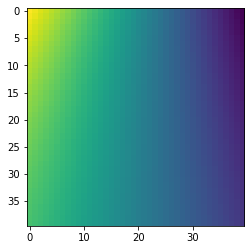

In [3]:
print(polydata[4])

_ = plt.imshow(polydata[3])

In [4]:
input_size = size**2
hidden_size = 2
output_size = size**2

polydata = polydata.reshape(num_polys, size**2)

inputs = Input(shape=(input_size,))

# autoencoder with a single hidden layer

# hidden layer
AE1encoded = Dense(2, activation='linear')(inputs)
# decoding
AE1decoded = Dense(size**2, activation='linear')(AE1encoded)
# we use linear activations for bottleneck and output because our data can be negative

AE1 = Model(inputs, AE1decoded)
AE1.compile(optimizer='adam', loss='mse')
AE1_initial_weights = AE1.get_weights()

# autoencoder with multiple hidden layers

AE2compress1 = Dense(512, activation='relu')(inputs)
AE2compress2 = Dense(64, activation='relu')(AE2compress1)

AE2encoded = Dense(2, activation='linear')(AE2compress2)


AE2decompress1 = Dense(64, activation='relu')(AE2encoded)
AE2decompress2 = Dense(512, activation='relu')(AE2decompress1)
AE2decoded = Dense(size**2, activation='linear')(AE2decompress2)

AE2 = Model(inputs, AE2decoded)
AE2.compile(optimizer='adam', loss='mse')
AE2_initial_weights = AE2.get_weights()

In [5]:
# train one layer encoder
hist = AE1.fit(polydata, polydata, epochs=10, batch_size=100)

Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 3s 852us/sample - loss: 0.0206
Epoch 2/10
3000/3000 [==============================] - 0s 73us/sample - loss: 0.0098
Epoch 3/10
3000/3000 [==============================] - 0s 87us/sample - loss: 0.0068
Epoch 4/10
3000/3000 [==============================] - 0s 92us/sample - loss: 0.0055
Epoch 5/10
3000/3000 [==============================] - 0s 66us/sample - loss: 0.0039
Epoch 6/10
3000/3000 [==============================] - 0s 71us/sample - loss: 0.0032
Epoch 7/10
3000/3000 [==============================] - 0s 156us/sample - loss: 0.0030
Epoch 8/10
3000/3000 [==============================] - 0s 66us/sample - loss: 0.0030
Epoch 9/10
3000/3000 [==============================] - 0s 64us/sample - loss: 0.0030
Epoch 10/10
3000/3000 [==============================] - 0s 84us/sample - loss: 0.0030


In [6]:
# compile and train the larger autoencoder
hist_large = AE2.fit(polydata, polydata, epochs=10, batch_size=100)

Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 2s 634us/sample - loss: 0.0119
Epoch 2/10
3000/3000 [==============================] - 1s 330us/sample - loss: 0.0046
Epoch 3/10
3000/3000 [==============================] - 1s 353us/sample - loss: 0.0032
Epoch 4/10
3000/3000 [==============================] - 1s 466us/sample - loss: 0.0028s - loss:
Epoch 5/10
3000/3000 [==============================] - 1s 336us/sample - loss: 0.0025
Epoch 6/10
3000/3000 [==============================] - 1s 324us/sample - loss: 0.0024
Epoch 7/10
3000/3000 [==============================] - 1s 344us/sample - loss: 0.0023
Epoch 8/10
3000/3000 [==============================] - 1s 381us/sample - loss: 0.0022
Epoch 9/10
3000/3000 [==============================] - 1s 386us/sample - loss: 0.0023
Epoch 10/10
3000/3000 [==============================] - 1s 414us/sample - loss: 0.0021


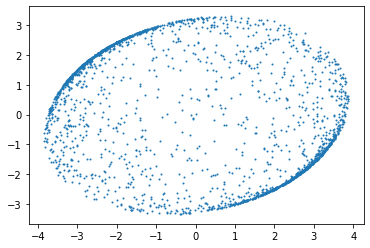

In [7]:
# one layer autoencoder

# model which computes the output of the hidden layer
AE1_latent = Model(inputs, AE1encoded)

# plot latent dimensions
AE1_encoded = AE1_latent.predict(polydata)
AE1_encoded[:,0].shape
_ = plt.scatter(AE1_encoded[:,0], AE1_encoded[:,1],s=1)

Compare with PCA result

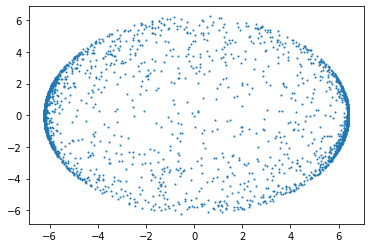

In [8]:
PCA_model = PCA(2)
PCA_polydata = PCA_model.fit_transform(polydata)
plt.scatter(PCA_polydata[:,0],PCA_polydata[:,1], s=1)

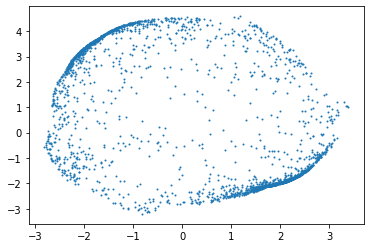

In [9]:
# more complex autoencoder

# model which computes the output of the hidden layer
AE2_latent = Model(inputs, AE2encoded)
# plot latent dimensions
AE2_encoded = AE2_latent.predict(polydata)
AE2_encoded[:,0].shape
plt.scatter(AE2_encoded[:,0], AE2_encoded[:,1],s=1)

#### Degree 2 polynomials

In [10]:
# degree two polynomials
Npoly = 3000
deg2polydata = np.array([polynomial(2) for i in range(Npoly)])
deg2polydata = deg2polydata.reshape(Npoly, size*size)
deg2mean = np.mean(deg2polydata)
deg2sdev = np.std(deg2polydata)
deg2polydata = tf.keras.utils.normalize(deg2polydata)

Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 0s 64us/sample - loss: 6.2581e-04
Epoch 2/10
3000/3000 [==============================] - 0s 63us/sample - loss: 6.2439e-04
Epoch 3/10
3000/3000 [==============================] - 0s 65us/sample - loss: 6.2344e-04
Epoch 4/10
3000/3000 [==============================] - 0s 63us/sample - loss: 6.2257e-04
Epoch 5/10
3000/3000 [==============================] - 0s 61us/sample - loss: 6.2061e-04
Epoch 6/10
3000/3000 [==============================] - 0s 61us/sample - loss: 6.1759e-04
Epoch 7/10
3000/3000 [==============================] - 0s 62us/sample - loss: 6.1248e-04
Epoch 8/10
3000/3000 [==============================] - 0s 64us/sample - loss: 6.0355e-040s - loss: 6.0608e
Epoch 9/10
3000/3000 [==============================] - 0s 62us/sample - loss: 5.9031e-04
Epoch 10/10
3000/3000 [==============================] - 0s 55us/sample - loss: 5.7076e-04


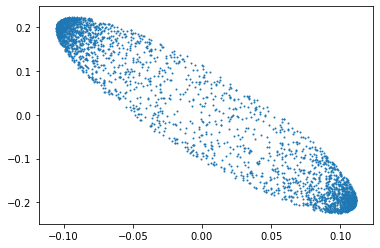

In [11]:
# train on degree 2 polynomials
AE1.set_weights(AE1_initial_weights)
# AE1.compile(optimizer='adam', loss='mse')
hist = AE1.fit(deg2polydata, deg2polydata, epochs=10, batch_size=100)

# plot the latent dimensions of the small encoder for polynomials of degree 2
AE1_encoded = AE1_latent.predict(deg2polydata)
_ = plt.scatter(AE1_encoded[:,0], AE1_encoded[:,1], s=1)

Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 1s 303us/sample - loss: 6.0821e-04
Epoch 2/10
3000/3000 [==============================] - 1s 317us/sample - loss: 3.0979e-04
Epoch 3/10
3000/3000 [==============================] - 1s 297us/sample - loss: 2.0960e-04s - loss: 2.0980e-
Epoch 4/10
3000/3000 [==============================] - 1s 302us/sample - loss: 1.6377e-04
Epoch 5/10
3000/3000 [==============================] - 1s 301us/sample - loss: 1.1076e-04s - lo
Epoch 6/10
3000/3000 [==============================] - 1s 312us/sample - loss: 1.0634e-04
Epoch 7/10
3000/3000 [==============================] - 1s 303us/sample - loss: 1.0517e-04
Epoch 8/10
3000/3000 [==============================] - 1s 299us/sample - loss: 1.0478e-04
Epoch 9/10
3000/3000 [==============================] - 1s 306us/sample - loss: 1.0439e-04
Epoch 10/10
3000/3000 [==============================] - 1s 302us/sample - loss: 1.0461e-04s - loss: 1.062


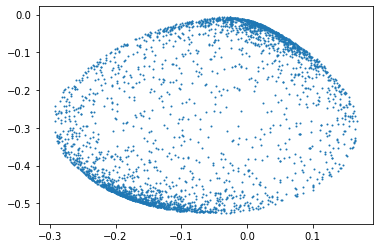

In [12]:
# train on degree 2 polynomials
AE2.set_weights(AE2_initial_weights)
# AE2.compile(optimizer='adam', loss='mse')
hist = AE2.fit(deg2polydata, deg2polydata, epochs=10, batch_size=100)

# plot the latent dimensions of the small encoder for polynomials of degree 2
AE2_encoded = AE2_latent.predict(deg2polydata)
_ = plt.scatter(AE2_encoded[:,0], AE2_encoded[:,1], s=1)

Let's have a look at how certain classes of polynomials are mapped

Text(0.5, 1.0, 'Pure linear polynomials')

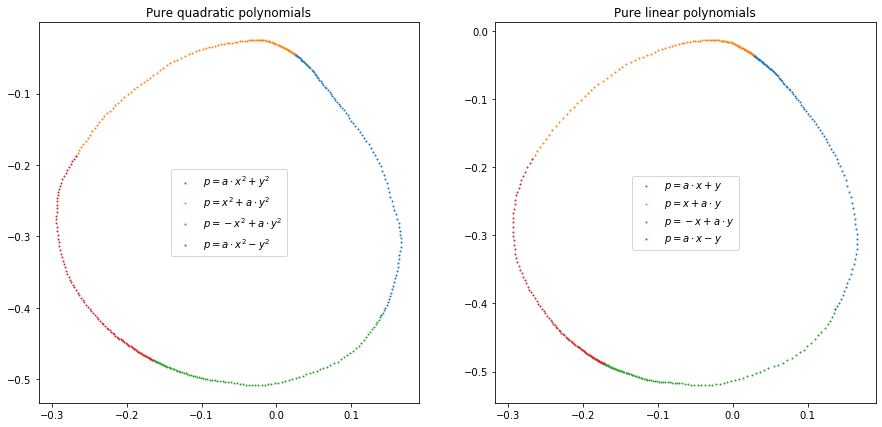

In [13]:
# poly=a*x^2+y^2
def poly_evaluate(curv_x, curv_y, slope_x, slope_y):
    return [[curv_x*((x/size)**2)+curv_y*((y/size)**2)+slope_x*(x/size)+slope_y*(y/size)
             for x in range(size)] for y in range(size)]

# run these polynomials through AE2
def predict(data):
    data = data.reshape(100, size**2)
    data = tf.keras.utils.normalize(data)
    return AE2_latent.predict(data)
    
fig, axs = plt.subplots(1,2, figsize=(15,7))

# quadratic
data = np.array([poly_evaluate(a,1,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(1,a,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(-1,a,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(a,-1,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)
axs[0].legend(['$p=a\cdot x^2+y^2$', '$p=x^2+a\cdot y^2$', '$p=-x^2+a\cdot y^2$', '$p=a\cdot x^2-y^2$'])
axs[0].set_title('Pure quadratic polynomials')

# linear
data = np.array([poly_evaluate(0,0,a,1) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,1,a) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,-1,a) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,a,-1) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)
axs[1].legend(['$p=a\cdot x+y$', '$p=x+a\cdot y$', '$p=-x+a\cdot y$', '$p=a\cdot x-y$'])
axs[1].set_title('Pure linear polynomials')

Latent dimensions are related to the coefficients of the polynomials.

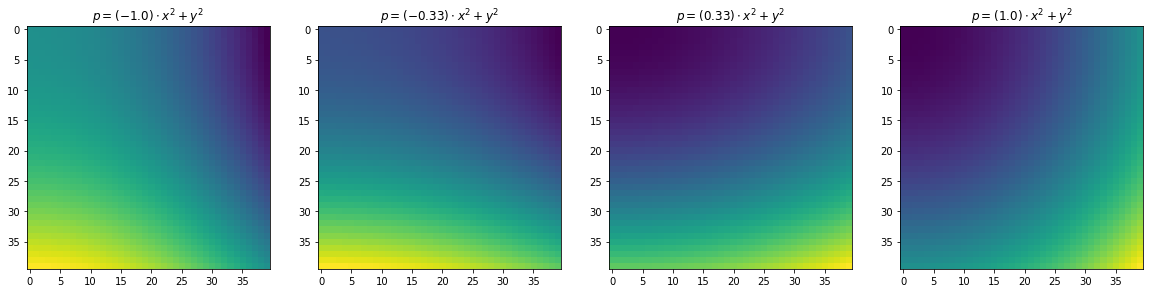

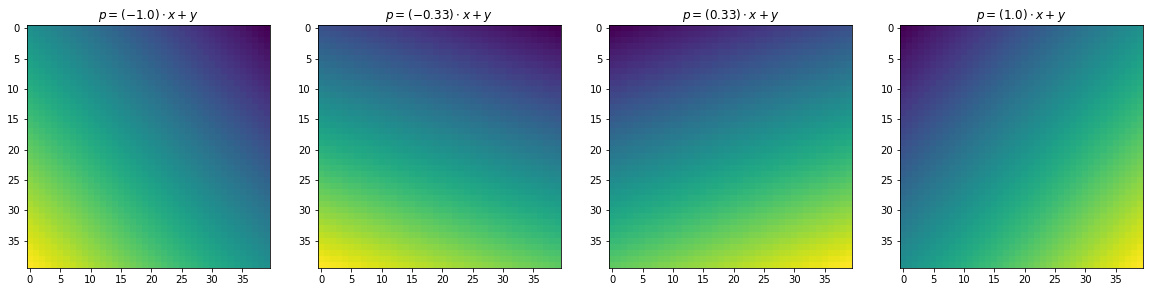

In [14]:
# plot a few inputs with varying average gradient
fig, axs = plt.subplots(1,4, figsize=(20,5))
for i, a in enumerate(np.linspace(-1,1,4)):
    axs[i].imshow(poly_evaluate(a,1,0,0))
    axs[i].set_title('$p=('+str(round(a,2))+')\cdot x^2+y^2$')
    
fig, axs = plt.subplots(1,4, figsize=(20,5))
for i, a in enumerate(np.linspace(-1,1,4)):
    axs[i].imshow(poly_evaluate(0,0,a,1))
    axs[i].set_title('$p=('+str(round(a,2))+')\cdot x+y$')

As we can see it is no coincidence that the latent representation for the linear and quadratic polynomials looks almost the same. The auto-encoder seems to primarily learn to represent the average gradient of the function.

#### Decorrelate latent variables:

In [15]:
# we wrap it by a function that can take arbitrary arguments and spits out the actual loss function
def custom_loss(layer):
    def loss(y_true, y_pred):
        X = layer[:,0]
        X = tf.expand_dims(X, axis=1)
        Y = layer[:,1]
        Y = tf.expand_dims(Y, axis=1)
        latent_loss = tfp.stats.covariance(X,Y)[0,0]**2
        return (tf.losses.mean_squared_error(y_true, y_pred)+(10**-1)*latent_loss)
    return loss

In [16]:
# train on degree 2 polynomials
AE2.set_weights(AE2_initial_weights)
AE2.compile(optimizer='adam', loss=custom_loss(AE2encoded))
hist = AE2.fit(deg2polydata, deg2polydata, epochs=10, batch_size=100)

# plot the latent dimensions of the small encoder for polynomials of degree 2
AE2_encoded = AE2_latent.predict(deg2polydata)
plt.scatter(AE2_encoded[:,0], AE2_encoded[:,1], s=1)

NameError: name 'tfp' is not defined

If we let this run long enough, we can observe that two clusters form in the latent space.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
    
data = np.array([poly_evaluate(a,1,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(1,a,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(-1,a,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(a,-1,0,0) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[0].scatter(pred[:,0], pred[:,1], s=1)
axs[0].legend(['$p=a\cdot x^2+y^2$', '$p=x^2+a\cdot y^2$', '$p=-x^2+a\cdot y^2$', '$p=a\cdot x^2-y^2$'])
axs[0].set_title('Pure quadratic polynomials')

data = np.array([poly_evaluate(0,0,a,1) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,1,a) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,-1,a) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)

data = np.array([poly_evaluate(0,0,a,-1) for a in np.linspace(-1,1,100)])
pred = predict(data)
axs[1].scatter(pred[:,0], pred[:,1], s=1)
axs[1].legend(['$p=a\cdot x+y$', '$p=x+a\cdot y$', '$p=-x+a\cdot y$', '$p=a\cdot x-y$'])
axs[1].set_title('Pure linear polynomials')